<a href="https://colab.research.google.com/github/PawinData/TM/blob/main/TM_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import namedtuple

In [46]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=19)  # read in training set
twenty_test  = fetch_20newsgroups(subset='test',  shuffle=True, random_state=29)  # read in test set

print("There are", len(twenty_train.filenames), "files in the training set under", len(twenty_train.target_names), "categories: \n")
for title in twenty_train.target_names:
    print(title)
print("")
print("There are", len(twenty_test.filenames), "files in the test set under", len(twenty_test.target_names), "categories.")

There are 11314 files in the training set under 20 categories: 

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc

There are 7532 files in the test set under 20 categories.


In [60]:
# organize evaluation metrics with namedtuples
Train = namedtuple("Train", ["Precision","Recall","F1"])
Test  = namedtuple("Test", ["Precision","Recall","F1"])

def evaluate(truth, predicted, which_set):
    P = precision_score(truth, predicted, average="macro")
    R = recall_score(truth, predicted, average="macro")
    F = f1_score(truth, predicted, average="macro")
    if which_set=="Train":
        return Train(P,R,F)  
    else:
         return Test(P,R,F)

In [97]:


def viz_res(DF, title=None, FigSize=(12,8), MarkerSize=12):
    fig,ax = plt.subplots(figsize=FigSize)
    for which_set in DF.columns:
        CLR = "darkblue" if which_set=="Train" else "darkolivegreen"
        ax.plot(DF.index, [cell.Precision for cell in DF[which_set]],
                color=CLR, marker="o", markersize=MarkerSize, linewidth=0,
                label="Precision for "+str(which_set)+" Set")
        ax.plot(DF.index, [cell.Recall for cell in DF[which_set]],
                color=CLR, marker="x", markersize=MarkerSize, linewidth=0,
                label="Recall for "+str(which_set)+" Set")
        ax.plot(DF.index, [cell.F1 for cell in DF[which_set]],
                color=CLR, marker="^", markersize=MarkerSize, linewidth=0,
                label="F1 for "+str(which_set)+" Set")
    for elements in ax.lines:
        xs = elements.get_xydata()[:,0]
        jittered_xs = xs + np.random.uniform(-0.25, 0.25, xs.shape)
        elements.set_xdata(jittered_xs)
        ax.relim()
        ax.autoscale(enable=True)
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Score", fontsize=18)
    plt.ylim((0.6,1.1))
    plt.title(title, fontsize=20)
    plt.legend(loc="upper center", fontsize=16)
    if title is not None:
        plt.savefig(title+".eps")
    plt.show()

# Naive Bayes Classifier

In [65]:
NB = dict()

In [66]:
# Train from Counts
NB_from_Counts = Pipeline([("vec_count", CountVectorizer()), ("clf", MultinomialNB())])
NB_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_Counts.predict(twenty_test.data)
# evaluate
NB["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [69]:
# Train from Term Frequency
NB_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ('clf',MultinomialNB())])
NB_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_TF.predict(twenty_test.data)
# evaluate
NB["TF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [71]:
# Train from Term Frequency times Inverse Document Frequency
NB_from_tfIDF = Pipeline([('vec_count',CountVectorizer()), ('tfidf',TfidfTransformer()), ('clf', MultinomialNB()),])
NB_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_tfIDF.predict(twenty_test.data)
# evaluate
NB["tfIDF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [75]:
# Organize results in a dataframe
NaiveBayes = pd.DataFrame(NB, index=["Train","Test"]).transpose()
NaiveBayes

,Train,Test
Counts,"(0.9348166390487324, 0.9228833755043991, 0.910...","(0.7621626411174734, 0.7636463041415988, 0.745..."
TF,"(0.8929939646270284, 0.819943011113042, 0.8114...","(0.7924314057319584, 0.6821951093902918, 0.672..."
tfIDF,"(0.9459403301595009, 0.9191027839411532, 0.919...","(0.8255310124210137, 0.756525006352595, 0.7557..."


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


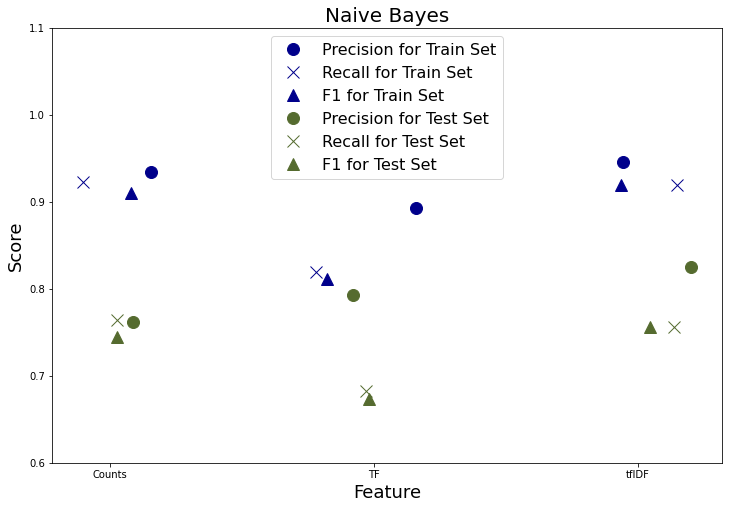

In [98]:
viz_res(NaiveBayes, title="Naive Bayes")

# Support Vector Machine

In [76]:
SVM = dict()

In [77]:
# Train from Counts
SVM_from_Counts = Pipeline([('vec_count', CountVectorizer()), 
                            ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=59,max_iter=5, tol=None)),
                          ])
SVM_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_Counts.predict(twenty_test.data)
# evaluate
SVM["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [79]:
# Train from Term Frequency
SVM_from_TF = Pipeline([('vec_count', CountVectorizer()),
                        ('tf', TfidfTransformer(use_idf=False)),
                        ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=79,max_iter=5, tol=None)),
                       ])
SVM_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_TF.predict(twenty_test.data)
# evaluate
SVM["TF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [81]:
# Train from Term Frequency times Inverse Document Frequency
SVM_from_tfIDF = Pipeline([('vec_count', CountVectorizer()),
                           ('tfIDF', TfidfTransformer()),
                           ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=89,max_iter=5, tol=None)),
                          ])
SVM_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_tfIDF.predict(twenty_test.data)
# evaluate
SVM["tfIDF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [83]:
# Organize results in a dataframe
SupportVectorMachine = pd.DataFrame(SVM, index=["Train","Test"]).transpose()
SupportVectorMachine

,Train,Test
Counts,"(0.9824892496018329, 0.9815918034591045, 0.981...","(0.7632170414670428, 0.7504747715611877, 0.752..."
TF,"(0.9176231701818622, 0.9055953533969816, 0.907...","(0.7789606373330445, 0.760413000061468, 0.7561..."
tfIDF,"(0.9676615733861244, 0.9619546416193036, 0.963...","(0.8267458608117908, 0.8120874662717542, 0.810..."


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


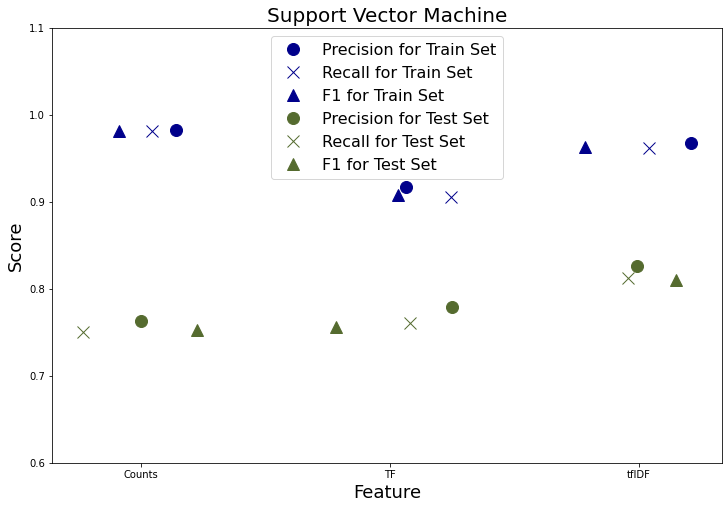

In [109]:
viz_res(SupportVectorMachine, title="Support Vector Machine")

# Decision Trees

# Compare

In [ ]:
Evaluations = dict()
Evaluations["Naive Bayes"] = NaiveBayes